In [1]:
from skimage.metrics import structural_similarity as ssim

import sys
sys.path.append('../')
from Helpers import MSE, SSIM, MapSimilarityMetric
import math
import matplotlib
#matplotlib.use('Agg')
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn

import numpy as np
import random as rn
import os
import hickle as hkl
import argparse
import yaml

from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as F
from AttentionPredNetOriginalV3 import AttentionPredNetOriginalV3
from six.moves import cPickle
from time import time
#from kitti_settings import *
from kitti_data import KITTI
from torch.utils.data import DataLoader

seed = 123
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True

In [2]:
"""Mod1:
 -Using ConvLSTMCellPredNet
 -AttCovnLSTM with peephole
 -No fusing output
 -No bias in SpatioTemporalAttConv2d
 -Each head has a full dim
 """

'Mod1:\n -Using ConvLSTMCellPredNet\n -AttCovnLSTM with peephole\n -No fusing output\n -No bias in SpatioTemporalAttConv2d\n -Each head has a full dim\n '

In [3]:
CONFIG_PATH = ""

def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_iterable(i):
    return sum(1 for e in i)

config = load_config("../configs/V3_4layers_ATT4_4heads_250_250_waymo_2.yaml")

#Setting up the model
nt = config["model"]["nt"] # number of timesteps used for sequences in training
nb_layers = config["model"]["nb_of_layers"]
(n_channels, im_height, im_width) = tuple(config["model"]["input_shape"])
input_shape = (im_height, im_width, n_channels)
stack_sizes = (n_channels, *tuple(config["model"]["stack_sizes"]))
R_stack_sizes = stack_sizes
A_filt_sizes = tuple(config["model"]["A_filt_sizes"])
Ahat_filt_sizes = tuple(config["model"]["Ahat_filt_sizes"])
R_filt_sizes = tuple(config["model"]["R_filt_sizes"])
layers_type = config["model"]["type_of_all_layers"]
attention_horizon = config["model"]["attention_horizon"]
Nh = config["model"]["Nh"]
dk = config["model"]["key_query_dimension"]
dv = config["model"]["value_dimension"]

#Setting up training
model_name = config["training"]["model_name"]
data_directory = config["training"]["dataset_path"]
nb_epoch = config["training"]["nb_epochs"]
batch_size = 1 #config["training"]["batch_size"]
samples_per_epoch =  config["training"]["samples_per_epoch"]
N_seq_val = config["training"]["N_seq_val"]
save_model = config["training"]["save_model"]

val_file = os.path.join("../"+data_directory, 'X_test.hkl')
val_sources = os.path.join("../"+data_directory, 'sources_test.hkl')
kitti_val = KITTI(val_file, val_sources, nt, mode='unique')
val_loader = DataLoader(kitti_val, batch_size=batch_size, shuffle=False)
val_size = count_iterable(val_loader)
print(val_size)
model = AttentionPredNetOriginalV3(layers_type, stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes, attention_horizon,
                  dk, dv, Nh, im_width, im_height, output_mode ='prediction',
                  extrap_start_time = 5, positional_encoding= True)

checkpoint = torch.load("../models/{}/{}_t+5.pt".format(model_name, model_name))
model.load_state_dict(checkpoint['model_state_dict'])

if torch.cuda.is_available():
    print('Using GPU.')
    model = model.cuda()

model = model.eval()

print(count_parameters(model))

(23507, 128, 128, 2)
1071
Forget_bias: 1.0
SpatialAttention check: True
SpatialAttention check: True
SpatialAttention check: True
SpatialAttention check: True
Using GPU.
7222094


In [4]:
X_test = np.zeros((val_size,nt,128,128,1))
X_hat = np.zeros((val_size,nt,128,128,1))
mse_model = 0
ssim_model = 0

with torch.no_grad():

    for i, inputs in enumerate(val_loader):
        
        if i%50==0:
            print(i)

        inputs = inputs.permute(0, 1, 4, 2, 3)# batch x time_steps x channel x width x height
        inputs = inputs.cuda()
        prediction = model(inputs) # batch x n_layers x nt

        output_tensor_prednet = prediction.permute(0,1,3,4,2).cpu().data.numpy()
        input_tensor = inputs.permute(0, 1, 3, 4, 2).cpu().data.numpy()

        input_test = np.expand_dims(0.5*(input_tensor[:,:,:,:,0])+ 0.5*(1.-input_tensor[:,:,:,:,1]), axis=-1)
        output = np.expand_dims(0.5*(output_tensor_prednet[:,:,:,:,0])+ 0.5*(1.-output_tensor_prednet[:,:,:,:,1]), axis=-1)

        X_test[i,:] = input_test
        X_hat[i,:] = output

mse_model,_ = MSE(X_test,X_hat, start_time=5) 
mse_prev = np.mean( (X_test[:, :-1] - X_test[:, 1:])**2)

num_images, num_timesteps, _, _, _ = X_test.shape

# ssim_values = []


print("Model: {} MSE Score: {}".format(model_name, mse_model))
#print("Model: {} SSIM Score: {}".format(model_name,ssim_model))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
Model: V3_4layers_ATT4_4heads_250_250_waymo_2 MSE Score: 0.02333548620645462


In [5]:
mse_pred,_ = MSE(X_test,X_hat, start_time=5) 
print("MSE Score of prediction: {}".format(mse_pred))
mse_seq,_ = MSE(X_test,X_hat, start_time=1) 
print("MSE Score of entire sequence: {}".format(mse_seq))
# ssim_pred,_ = SSIM(X_test,X_hat, start_time=5) 
# print("MSE Score of prediction: {}".format(ssim_pred))
# ssim_seq,_ = SSIM(X_test,X_hat, start_time=1) 
# print("MSE Score of entire sequence: {}".format(ssim_seq))

MSE Score of prediction: 0.02333548620645462
MSE Score of entire sequence: 0.020358591281914466


In [6]:
data = []
data_label = []
data.append(X_hat)
data_label.append(model_name)
np.save("../export/TAAConvLSTM_Waymo_Batch_2_Prediction_20", X_hat[:,:,:,:,0])
np.save("../export/X_test_Waymo_20", X_test)

(1, 20, 128, 128)
(1, 20, 128, 128)


/home/bernard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/bernard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

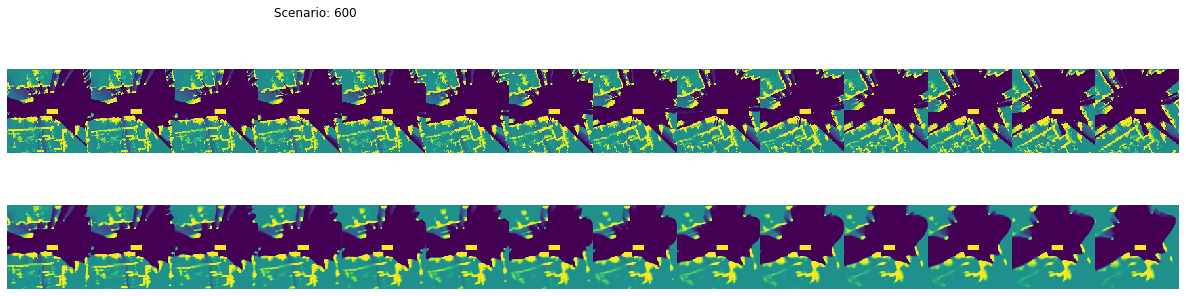

<Figure size 432x288 with 0 Axes>

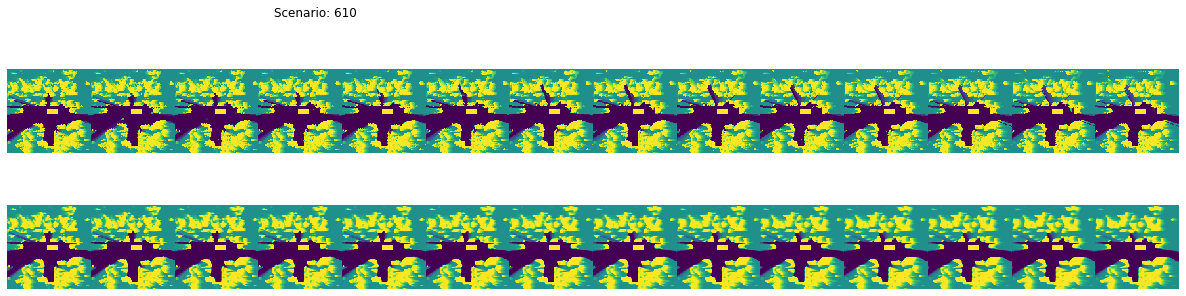

<Figure size 432x288 with 0 Axes>

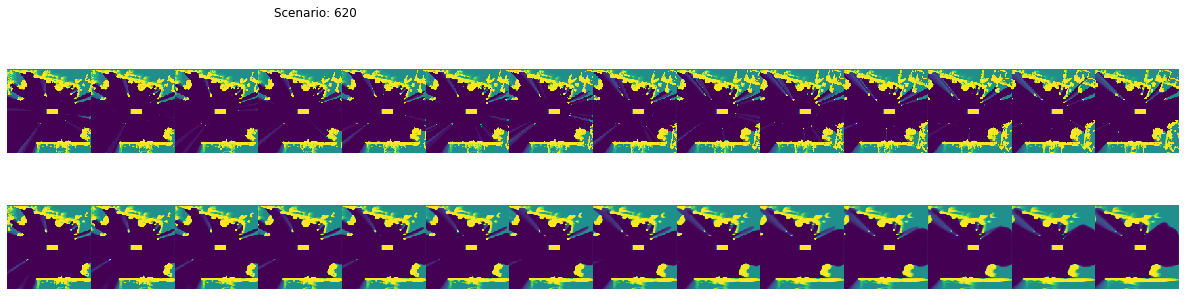

<Figure size 432x288 with 0 Axes>

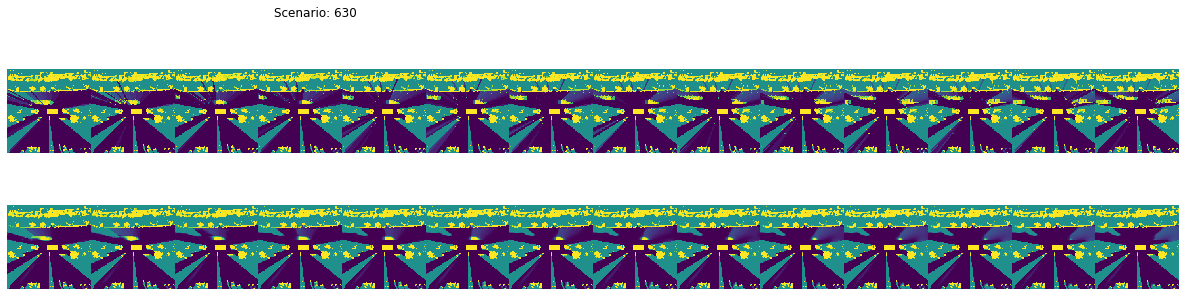

<Figure size 432x288 with 0 Axes>

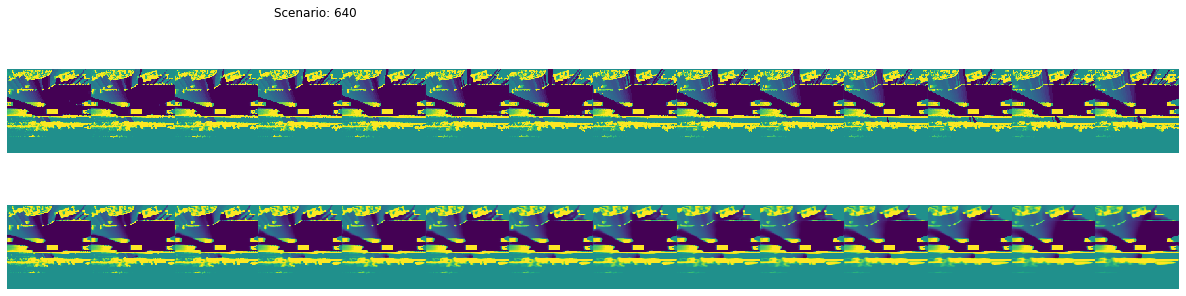

<Figure size 432x288 with 0 Axes>

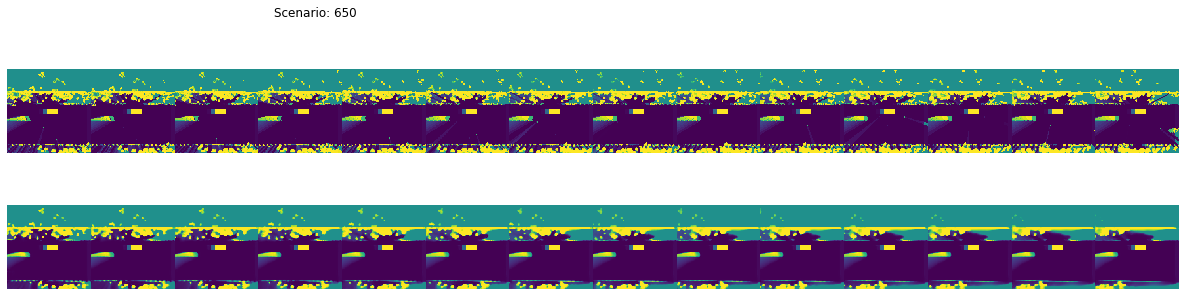

<Figure size 432x288 with 0 Axes>

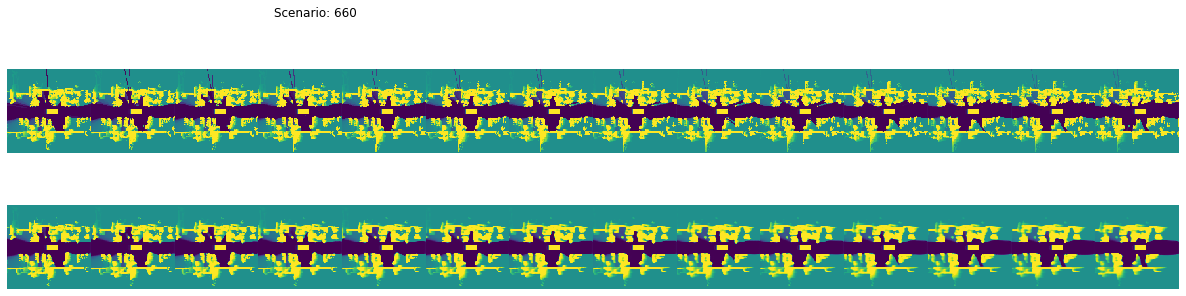

<Figure size 432x288 with 0 Axes>

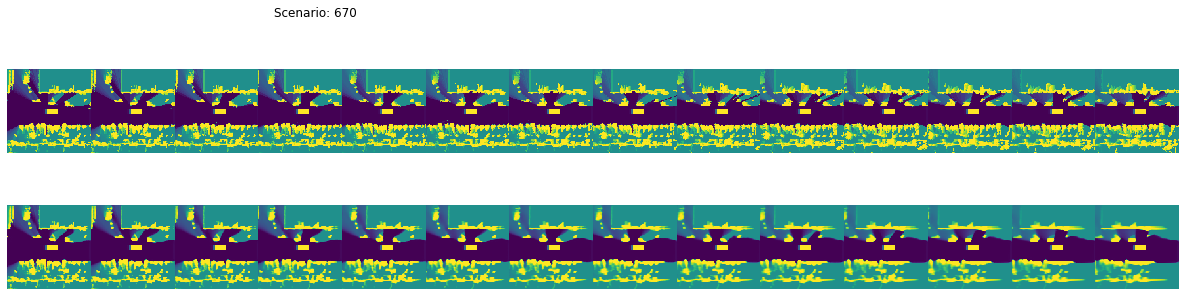

<Figure size 432x288 with 0 Axes>

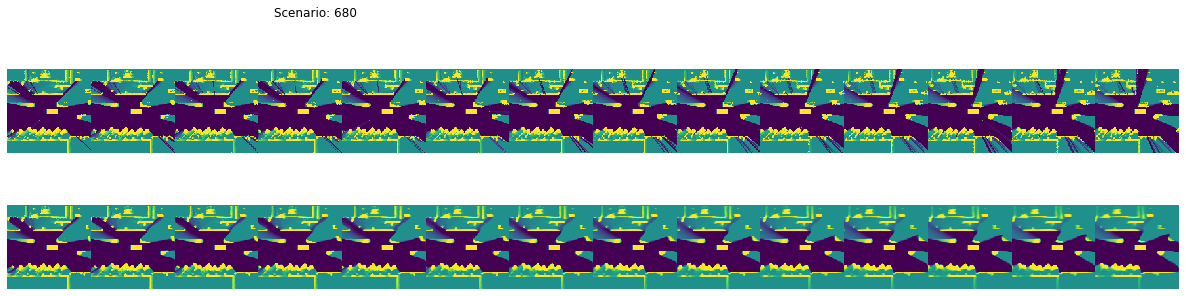

<Figure size 432x288 with 0 Axes>

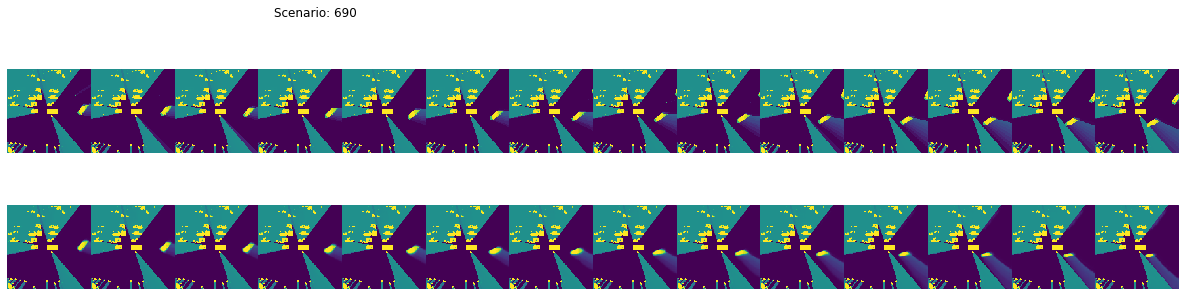

<Figure size 432x288 with 0 Axes>

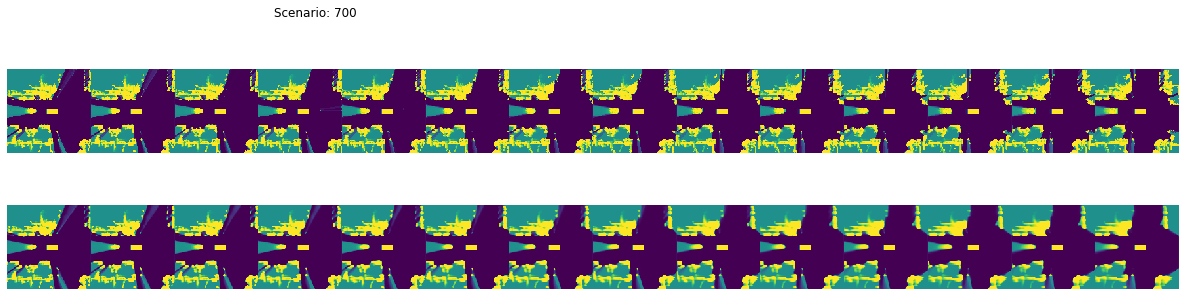

<Figure size 432x288 with 0 Axes>

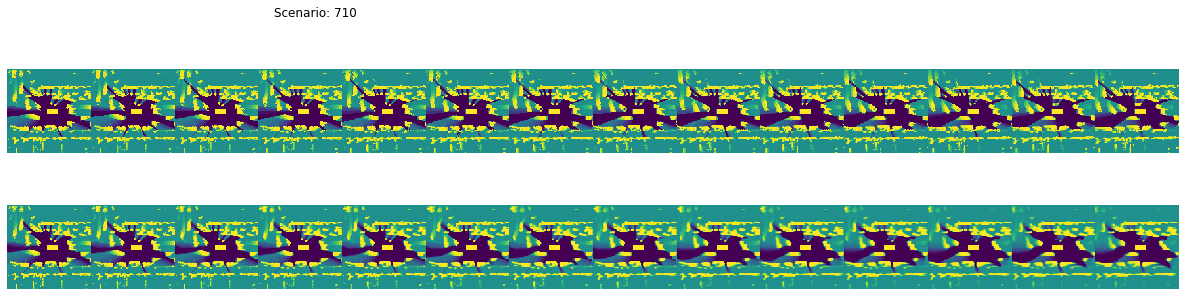

<Figure size 432x288 with 0 Axes>

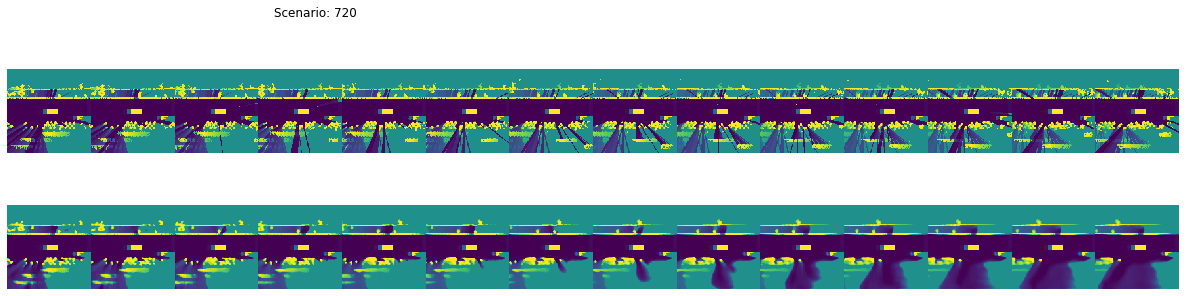

<Figure size 432x288 with 0 Axes>

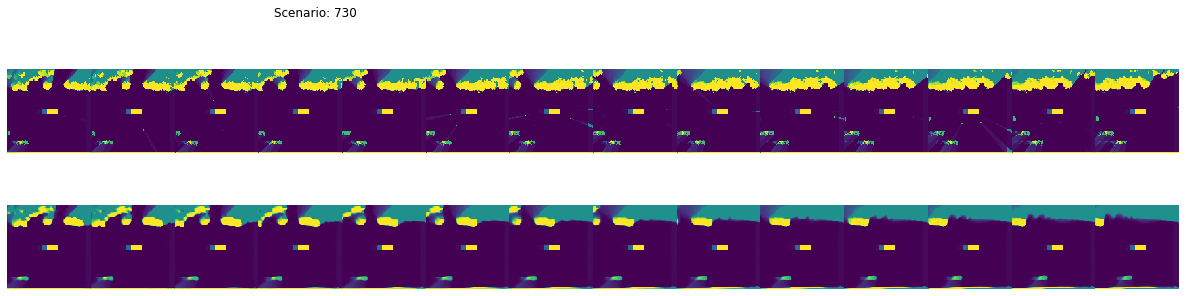

<Figure size 432x288 with 0 Axes>

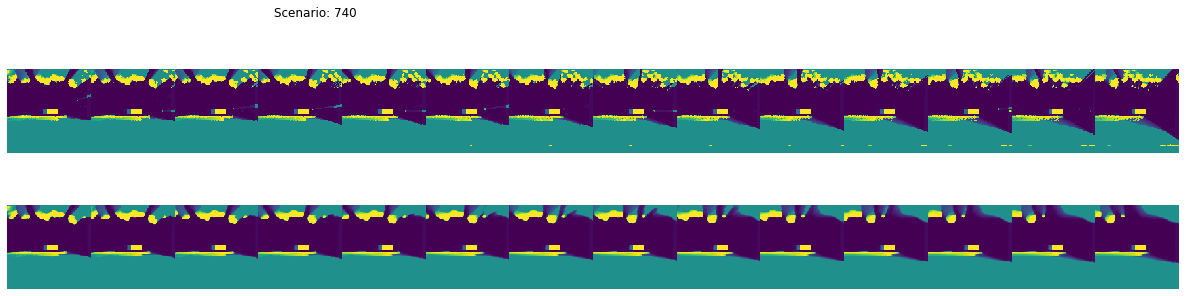

<Figure size 432x288 with 0 Axes>

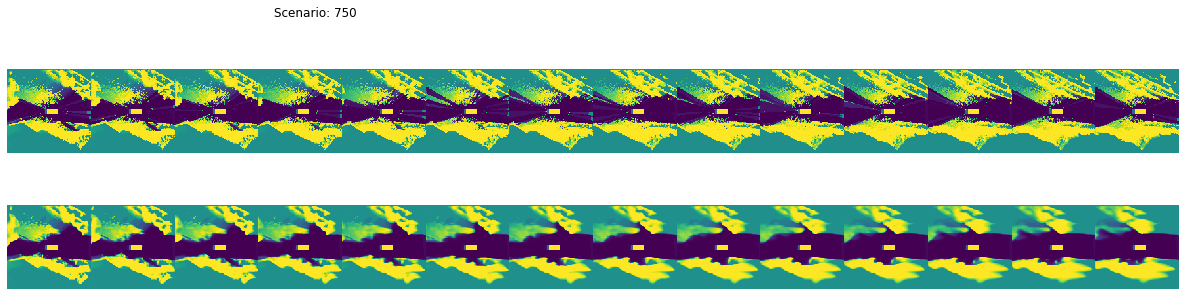

<Figure size 432x288 with 0 Axes>

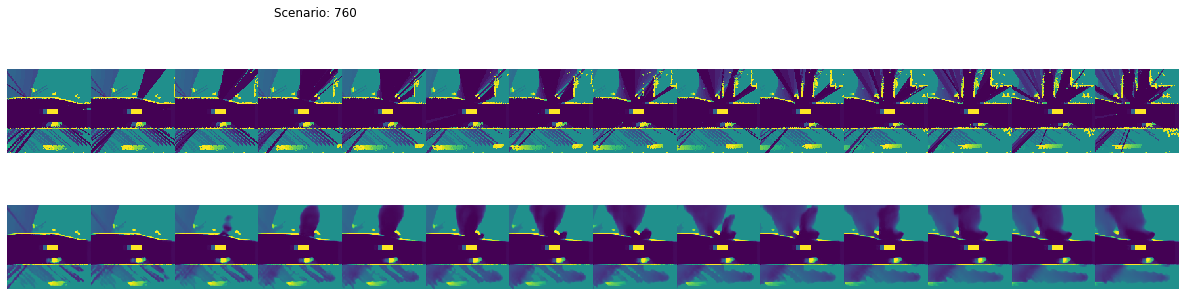

<Figure size 432x288 with 0 Axes>

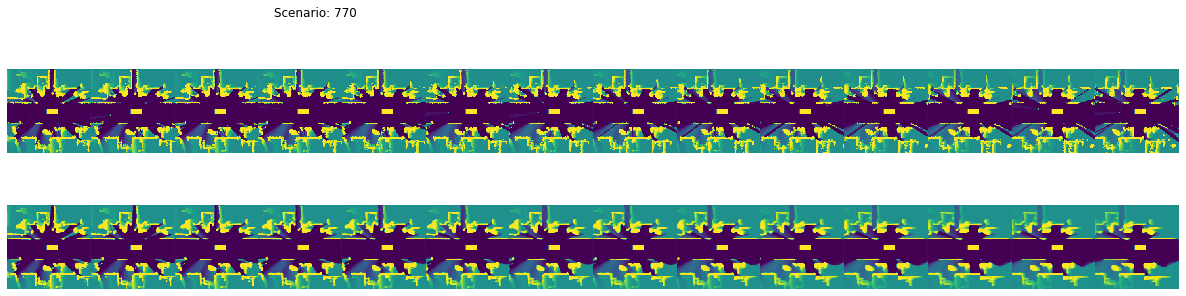

<Figure size 432x288 with 0 Axes>

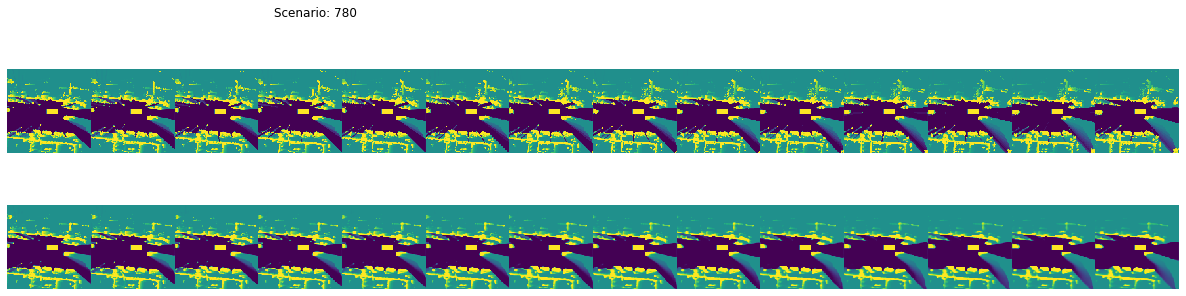

<Figure size 432x288 with 0 Axes>

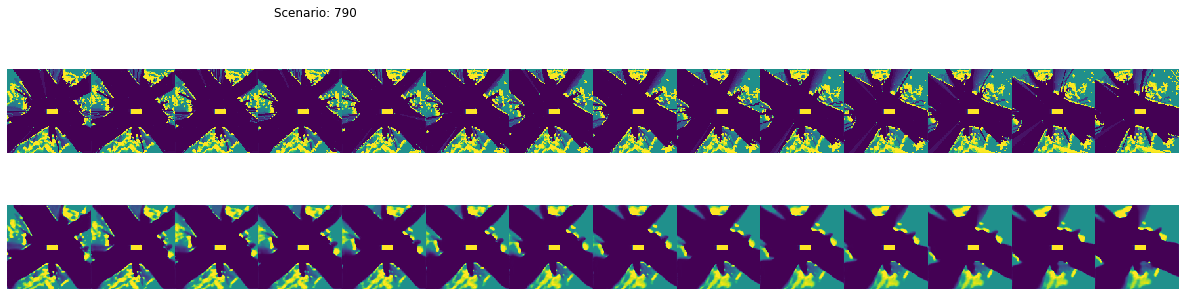

<Figure size 432x288 with 0 Axes>

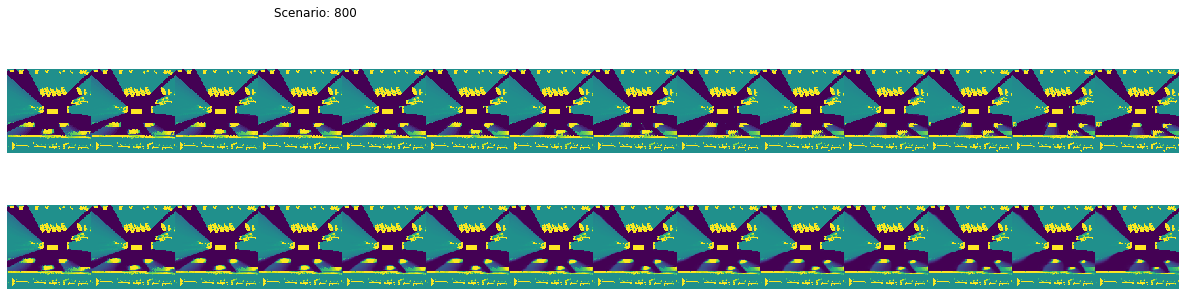

<Figure size 432x288 with 0 Axes>

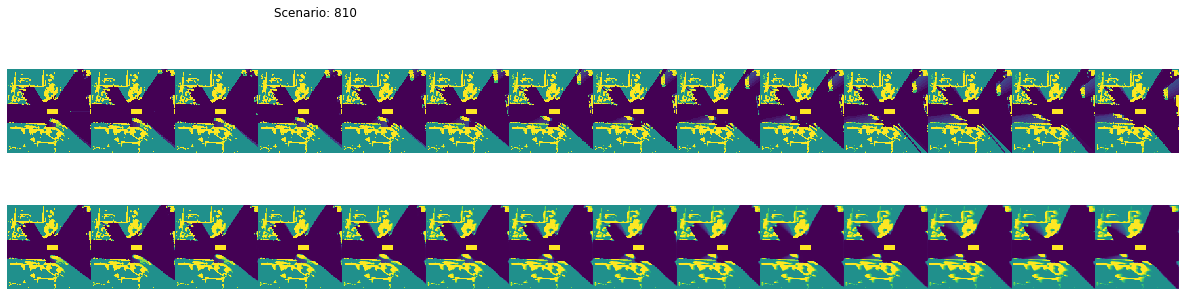

<Figure size 432x288 with 0 Axes>

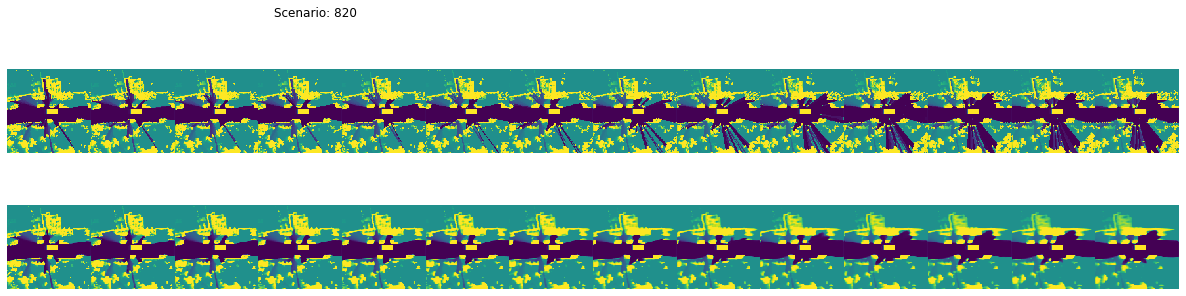

<Figure size 432x288 with 0 Axes>

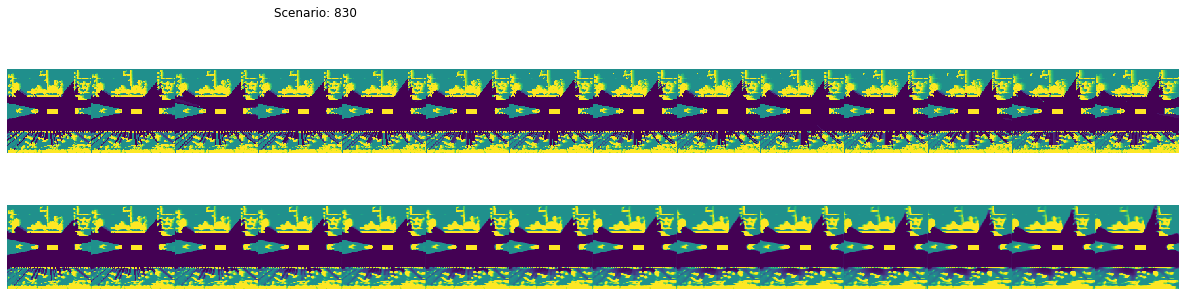

<Figure size 432x288 with 0 Axes>

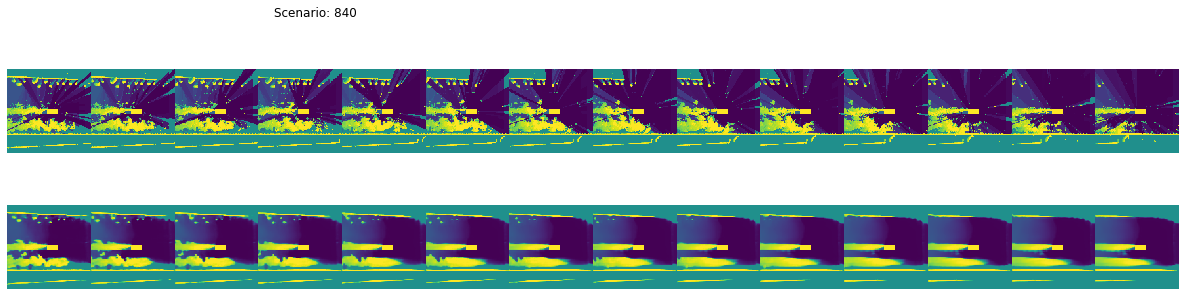

<Figure size 432x288 with 0 Axes>

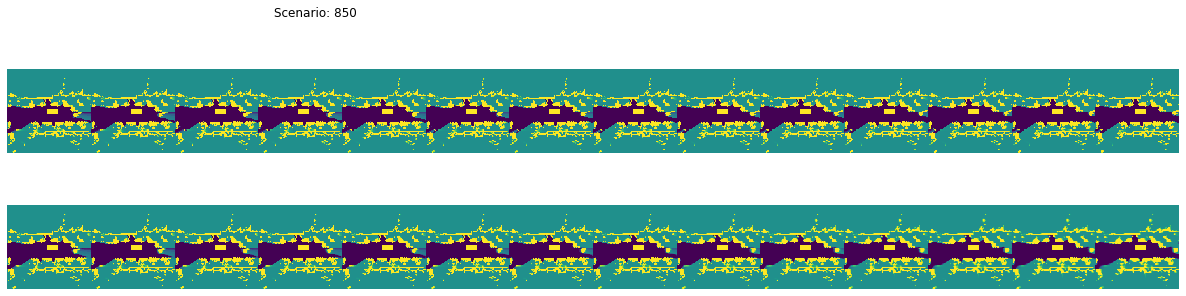

<Figure size 432x288 with 0 Axes>

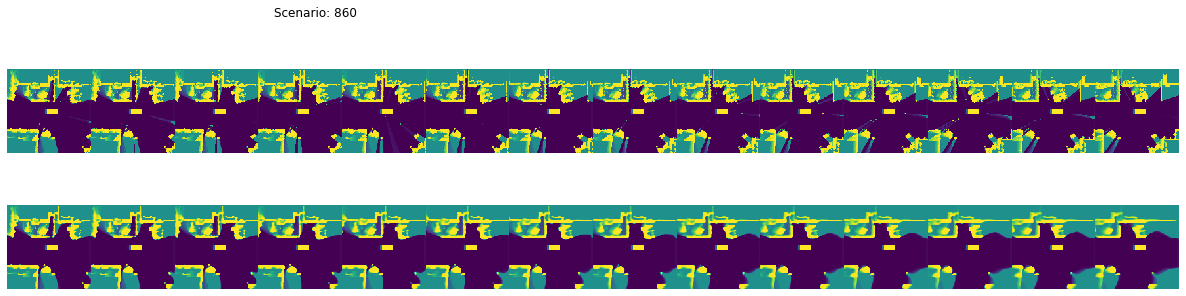

<Figure size 432x288 with 0 Axes>

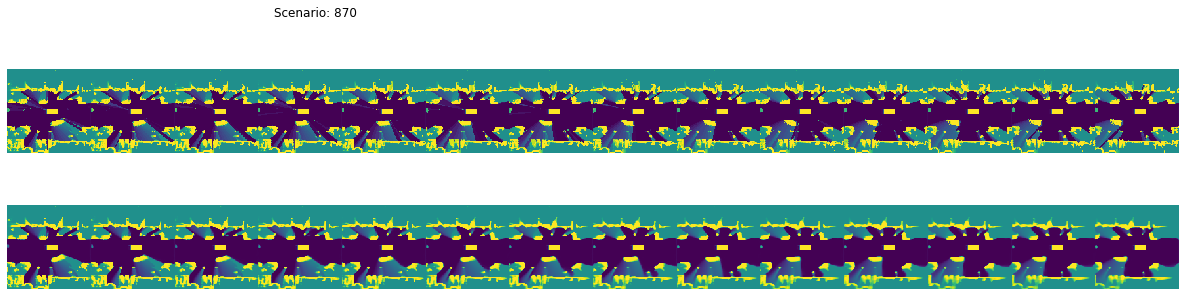

<Figure size 432x288 with 0 Axes>

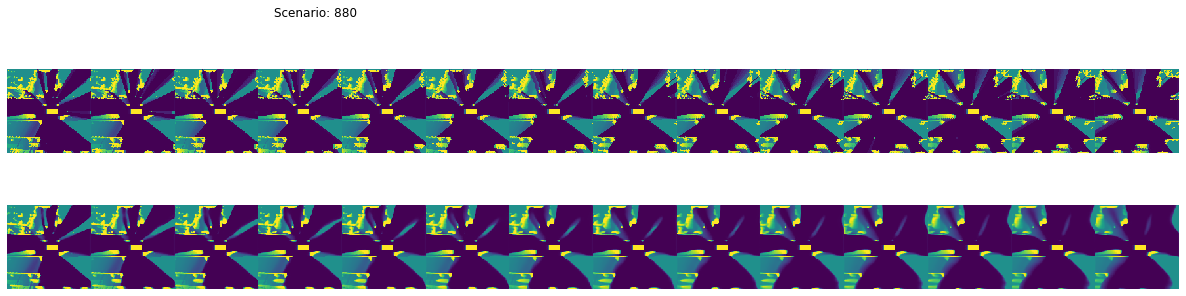

<Figure size 432x288 with 0 Axes>

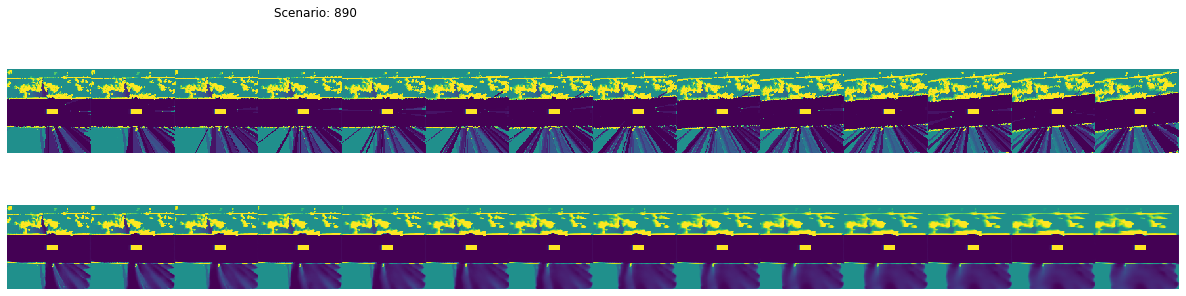

In [8]:
scenario_list = [525]
models_considered = [0,1]
print(X_hat[scenario_list,:,:,:,0].shape)
print(X_test[scenario_list,:,:,:,0].shape)
# np.save("../export/"+model_name+"_prediction_scenario_20", X_hat[scenario_list,:,:,:,0])
# np.save("../export/"+model_name+"_prediction_full_20", X_hat[:,:,:,:,0])
# np.save("../export/X_test_scenario_20", X_test[scenario_list,:,:,:,0])
#np.save("../export/X_test_full_20", X_test[:,:,:,:,0])
scenario_list = [105, 285, 370, 425, 430, 485, 500, 515, 525, 570]
img = 0

for i in range(600,900,10):
    num_models = len(data_label)
    aspect_ratio = float(X_test.shape[2]) / X_test.shape[3]
    plt.figure()
    fig = plt.figure(figsize = (2*(nt-5), 5.*aspect_ratio))
    gs = gridspec.GridSpec(num_models+1, nt) #All models and a ground truth.
    gs.update(wspace=0.0, hspace=0.0)
    fig.suptitle('Scenario: {}'.format(i))  
    for t in range(6,nt):

        plt.subplot(gs[t])
        plt.tick_params(bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        plt.axis('off')
        plt.imshow(X_test[i,t,:,:,0], interpolation='nearest')

        if t==6: plt.ylabel("Ground Truth", fontsize=10)
        idx = 0
        for model in range(num_models):
            plt.subplot(gs[t + (idx+1)*nt])
            X_hat = data[model]
            label = data_label[model]
            plt.tick_params(bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
            plt.axis('off')
            plt.imshow(X_hat[i,t,:,:,0], interpolation='nearest')

            plt.tick_params(bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
            if t==6: plt.ylabel("Model:" + str(model), fontsize=10)
            idx += 1
    num_images, num_timesteps, _, _, _ = X_test.shape



   # plt.savefig("final_output_" + str(img))
    img += 1